# QA Image - Llava 0.5b

## Quantize and load model

In [1]:
import os
import torch
import re
import json

from dotenv import load_dotenv
from transformers import (
    BitsAndBytesConfig,
    LlavaProcessor,
    LlavaForConditionalGeneration,
)
from utils import extract_frames, show_frame, convert_frame_to_bytes

# Load environment
load_dotenv()

# Quantize model for lower storage
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load model
model_id = "llava-hf/llava-interleave-qwen-0.5b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.float16,
    quantization_config=quantization_config,
)

# Load Prompt processor
processor = LlavaProcessor.from_pretrained(model_id)

/home/rapha/.cache/pypoetry/virtualenvs/clear-vision-backend-pHRXtyny-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Extract frames and their timestamps

In [2]:
video_path = os.path.abspath('../public/video_rua01.mp4')
frames, ts = extract_frames(video_path)
ts

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

## Build Prompt

In [3]:
def format_prompt(question: str):
    expected_response_format = (
        "Return ONLY JSON in the following format:\n"
        "{\"exists\": boolean, \"description\": string}\n"
        "- \"exists\" MUST strictly reflect if the target object is visible.\n"
        "- \"description\" MUST describe ALL visible objects in the frame.\n"
        "- Do NOT assume, guess, or infer anything not visible.\n"
        "- If the target is not present, \"exists\" must be false.\n"
    )

    context = (
        f"{expected_response_format}\n"
        f"Target object: \"{question}\"\n"
        f"First, analyze the image neutrally.\n"
        f"Then answer strictly based on visible evidence.\n"
    )

    prompt = (
        f"<|im_start|>user\n"
        f"<image>\n"
        f"{context}\n"
        f"<|im_end|>\n"
        f"<|im_start|>assistant\n"
    )

    return prompt

## Process one frame

In [ ]:
def format_response(response: str) -> dict:
    matches = re.search(r"(?<=assistant\n)\{[\s\S]*\}", response)

    if not matches:
        return {'exists': False, 'description': None}

    raw = matches.group(0)
    raw_dict = json.loads(raw)

    return raw_dict


def process_frame(frame, prompt):
    inputs = processor(
        text=format_prompt(prompt), images=frame, return_tensors="pt"
    ).to(model.device, model.dtype)

    output = model.generate(**inputs, max_new_tokens=200, do_sample=False)

    # MODEL DESCRIBES WELL THE IMAGE, HOWEVER IT IS STILL BIASED BY THE USER PROMPT (WONT DETECT EVERYTHING I EXPECTED ON THE IMAGE)
    response = processor.decode(output[0], skip_special_tokens=True)

    return format_response(response)

In [5]:
frame = frames[10]

process_frame(frame, 'black car crossing the street')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'Black car crossing the street'}

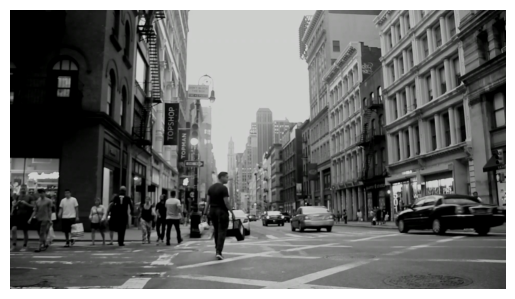

In [6]:
show_frame(frame)

In [7]:
convert_frame_to_bytes(frame)[:10]

b'\xff\xd8\xff\xe0\x00\x10JFIF'

## Process multiple frames

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing a street in a city setting.'}


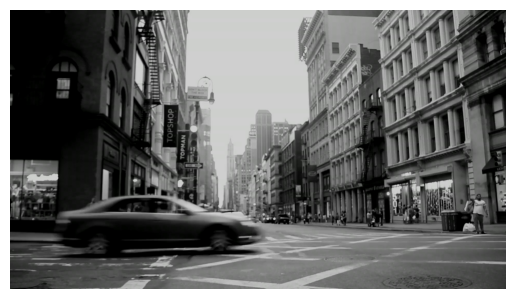

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


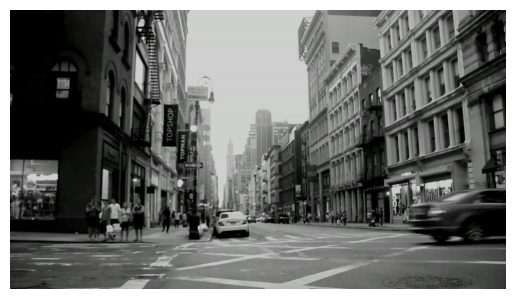

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


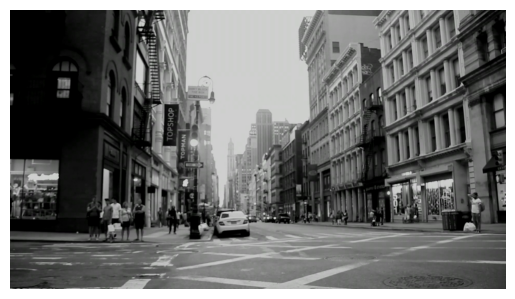

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


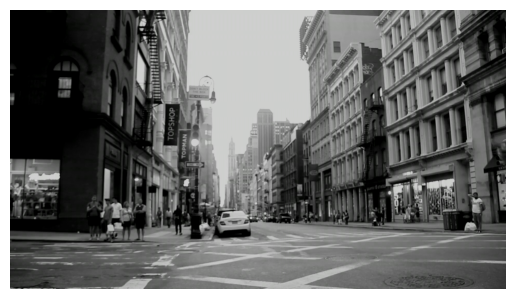

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street'}


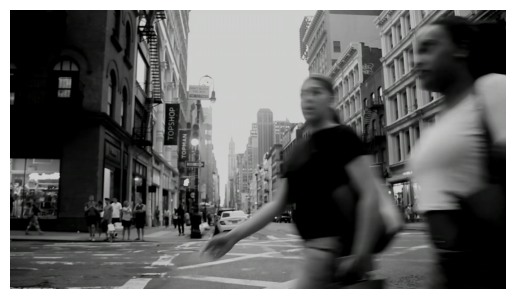

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{}


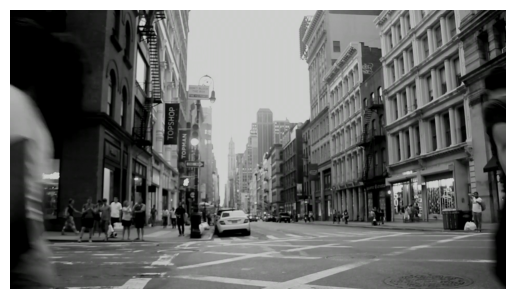

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{}


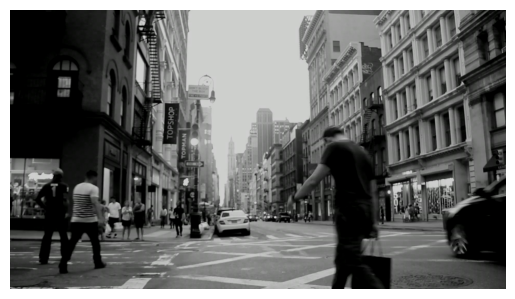

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street'}


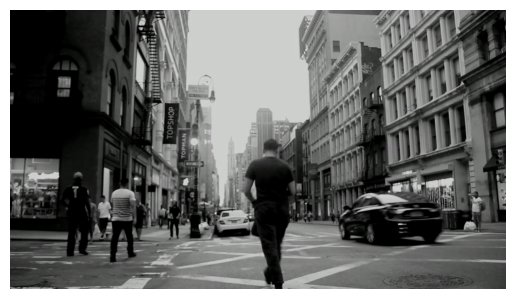

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street'}


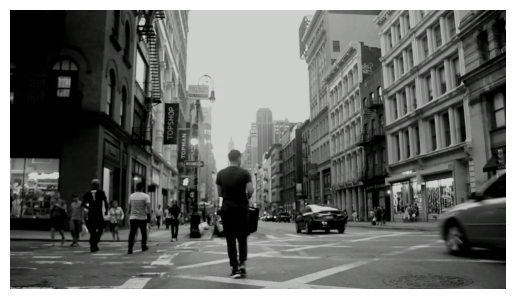

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street'}


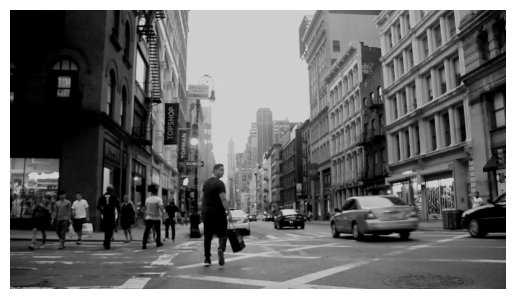

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street'}


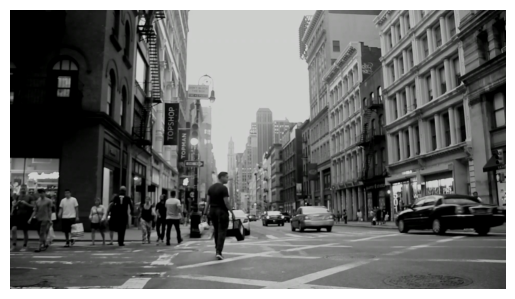

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


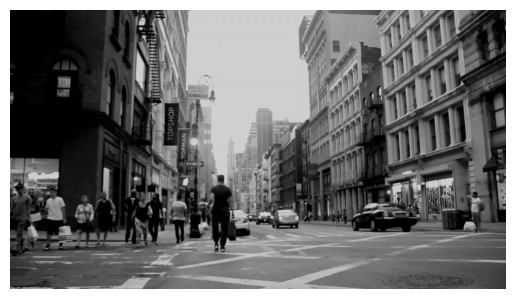

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': False, 'description': 'A car crossing the street in a city setting.'}


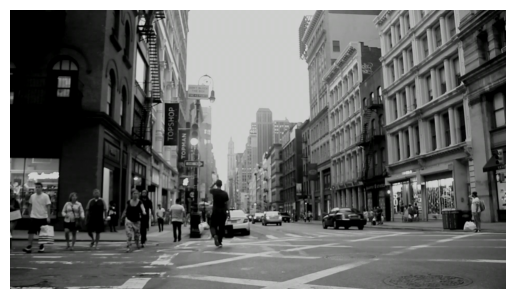

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


{'exists': True, 'description': 'A car crossing a street in a city setting.'}


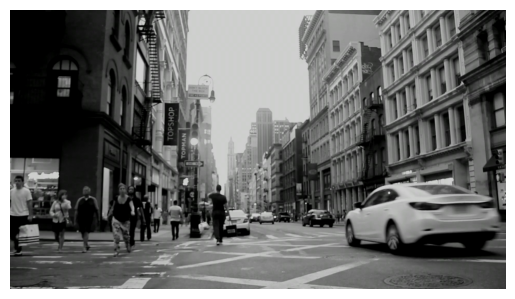

In [8]:
question = 'a car crossing the street'
for f in frames:
    print(
        process_frame(f, question)
    )
    show_frame(f)